# Assignment 2
Задача 1. Введение в гетерогенную параллелизацию
Теоретическое задание (25 баллов)
Объясните, что такое гетерогенная параллелизация.
В ответе раскройте следующие аспекты:

*   различия между параллельными вычислениями на CPU и GPU;
*   преимущества гетерогенной параллелизации;
*   примеры реальных приложений, в которых используется гетерогенная
параллелизация.

Задача 1. Введение в гетерогенную параллелизацию

**Гетерогенная параллелизация** — это способ выполнения вычислений, при котором используются разные вычислительные устройства, например CPU и GPU, и работа распределяется между ними. Это делается для того, чтобы ускорить выполнение программы, так как разные устройства лучше подходят для разных типов задач.

**Различия между параллельными вычислениями на CPU и GPU**

CPU и GPU имеют разную архитектуру и назначение.

CPU содержит небольшое количество мощных ядер и хорошо подходит для задач с логикой, условиями и последовательным выполнением операций. Он управляет программой и выполняет сложные вычисления.

GPU имеет большое количество простых ядер и предназначен для выполнения большого числа одинаковых операций одновременно. Он эффективен при работе с массивами данных и параллельными вычислениями.

**Преимущества гетерогенной параллелизации**
Основные преимущества гетерогенной параллелизации:

*   увеличение скорости выполнения программ;
*   более эффективное использование ресурсов компьютера;
*   возможность распределять задачи между CPU и GPU в зависимости от их типа;
*   сокращение времени обработки больших объёмов данных.

**Примеры реальных приложений**

Гетерогенная параллелизация используется во многих современных приложениях:

*   в машинном обучении и нейронных сетях;
*   при обработке изображений и видео;
*   в научных и инженерных расчётах;
*   в компьютерной графике и играх.

Задача 2. Работа с массивами и OpenMP
Практическое задание (25 баллов)
Реализуйте программу на C++, которая:
1. Создаёт массив из 10 000 случайных чисел.
2. Находит минимальное и максимальное значения массива:
o в последовательной реализации;
o с использованием OpenMP для параллельной обработки.
3. Сравнивает время выполнения обеих реализаций и формулирует выводы.
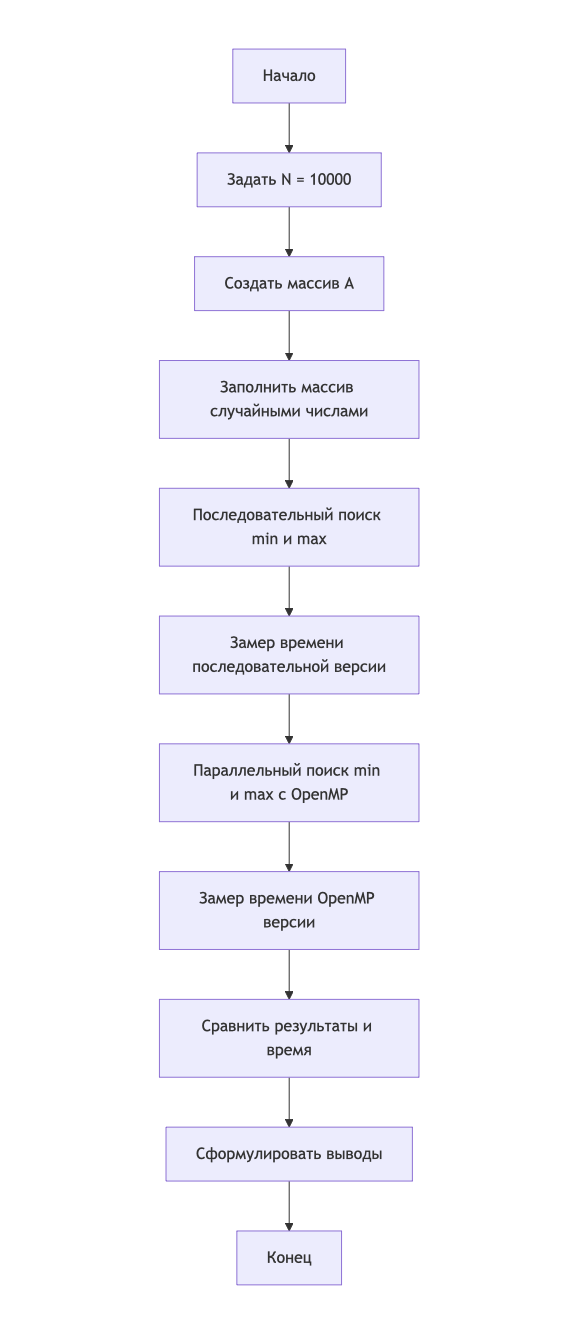

In [11]:
%%writefile task2.cpp
#include <iostream>                 // cout, endl
#include <vector>                   // vector
#include <random>                   // mt19937, uniform_int_distribution
#include <chrono>                   // high_resolution_clock
#include <omp.h>                    // OpenMP (omp_set_num_threads и директивы)

using namespace std;                // чтобы не писать std::

int main() {                        // старт программы
    const int N = 10000;            // по заданию: массив из 10 000 чисел
    const int REPEATS = 300;        // повторяем замер много раз для стабильного времени

    vector<int> a(N);               // создаём массив размера N

    mt19937 rng(42);                // генератор случайных чисел (фиксируем seed)
    uniform_int_distribution<int> dist(0, 1'000'000); // диапазон случайных чисел

    for (int i = 0; i < N; i++) {   // заполняем массив
        a[i] = dist(rng);           // случайное число в a[i]
    }

    // ---- можно задать число потоков (если среда разрешает) ----
    // omp_set_num_threads(4);      // раскомментируй и попробуй 2/4/8

    // -------------------- ПОСЛЕДОВАТЕЛЬНО --------------------
    int minSeq = 0;                 // переменная для min (последовательно)
    int maxSeq = 0;                 // переменная для max (последовательно)
    double seqSumMs = 0.0;          // сумма времени (для среднего)

    for (int r = 0; r < REPEATS; r++) { // повторяем замер
        minSeq = a[0];              // стартовое значение min
        maxSeq = a[0];              // стартовое значение max

        auto t1 = chrono::high_resolution_clock::now(); // начало таймера

        for (int i = 1; i < N; i++) { // обычный цикл
            if (a[i] < minSeq) minSeq = a[i]; // обновляем min
            if (a[i] > maxSeq) maxSeq = a[i]; // обновляем max
        }

        auto t2 = chrono::high_resolution_clock::now(); // конец таймера
        seqSumMs += chrono::duration<double, milli>(t2 - t1).count(); // добавляем время
    }

    double seqAvgMs = seqSumMs / REPEATS; // среднее время последовательной версии

    // -------------------- ПАРАЛЛЕЛЬНО (OpenMP) --------------------
    int minPar = 0;                 // переменная для min (параллельно)
    int maxPar = 0;                 // переменная для max (параллельно)
    double parSumMs = 0.0;          // сумма времени (для среднего)

    // "прогрев" OpenMP (первый запуск часто медленнее из-за инициализации)
    minPar = a[0];                  // стартовое значение min
    maxPar = a[0];                  // стартовое значение max
    #pragma omp parallel for reduction(min:minPar) reduction(max:maxPar)
    for (int i = 0; i < N; i++) {   // параллельный цикл
        if (a[i] < minPar) minPar = a[i]; // локальный min
        if (a[i] > maxPar) maxPar = a[i]; // локальный max
    }

    for (int r = 0; r < REPEATS; r++) { // повторяем замер
        minPar = a[0];              // стартовое значение min
        maxPar = a[0];              // стартовое значение max

        auto t3 = chrono::high_resolution_clock::now(); // начало таймера

        #pragma omp parallel for reduction(min:minPar) reduction(max:maxPar)
        for (int i = 0; i < N; i++) { // параллельный поиск
            if (a[i] < minPar) minPar = a[i]; // обновляем min в потоке
            if (a[i] > maxPar) maxPar = a[i]; // обновляем max в потоке
        }

        auto t4 = chrono::high_resolution_clock::now(); // конец таймера
        parSumMs += chrono::duration<double, milli>(t4 - t3).count(); // добавляем время
    }

    double parAvgMs = parSumMs / REPEATS; // среднее время OpenMP версии

    // -------------------- ВЫВОД И ПРОВЕРКА --------------------
    cout << "Array size: " << N << endl; // вывод N

    cout << "Sequential min = " << minSeq << ", max = " << maxSeq << endl; // seq min/max
    cout << "Parallel   min = " << minPar << ", max = " << maxPar << endl; // omp min/max

    cout << "Sequential avg time: " << seqAvgMs << " ms" << endl; // среднее seq время
    cout << "Parallel   avg time: " << parAvgMs << " ms" << endl; // среднее omp время

    bool ok = (minSeq == minPar) && (maxSeq == maxPar); // проверяем совпадение результатов
    cout << "Results are " << (ok ? "correct" : "NOT correct") << endl; // вывод корректности

    cout << "OpenMP threads (max): " << omp_get_max_threads() << endl; // сколько потоков доступно

    return 0; // конец программы
}


Overwriting task2.cpp


In [13]:
!g++ -O2 -fopenmp task2.cpp -o task2
!OMP_NUM_THREADS=8 ./task2

Array size: 10000
Sequential min = 11, max = 999718
Parallel   min = 11, max = 999718
Sequential avg time: 0.00706998 ms
Parallel   avg time: 0.0860652 ms
Results are correct
OpenMP threads (max): 8


### Вывод:
Для массива размером 10 000 элементов параллельная реализация с OpenMP оказалась медленнее последовательной. Это связано с тем, что время выполнения последовательного цикла очень мало (порядка микросекунд), и накладные расходы OpenMP (распределение итераций между потоками и операция reduction для min/max) превышают выигрыш от параллельного выполнения. При увеличении размера массива эффективность OpenMP обычно возрастает, и ускорение становится заметнее.

Задача 3. Параллельная сортировка с OpenMP
Практическое задание (25 баллов)
Реализуйте алгоритм сортировки выбором с использованием OpenMP:

*   напишите последовательную реализацию алгоритма;
*   добавьте параллелизм с помощью директив OpenMP;
*   проверьте производительность для массивов размером 1 000 и 10 000 элементов.
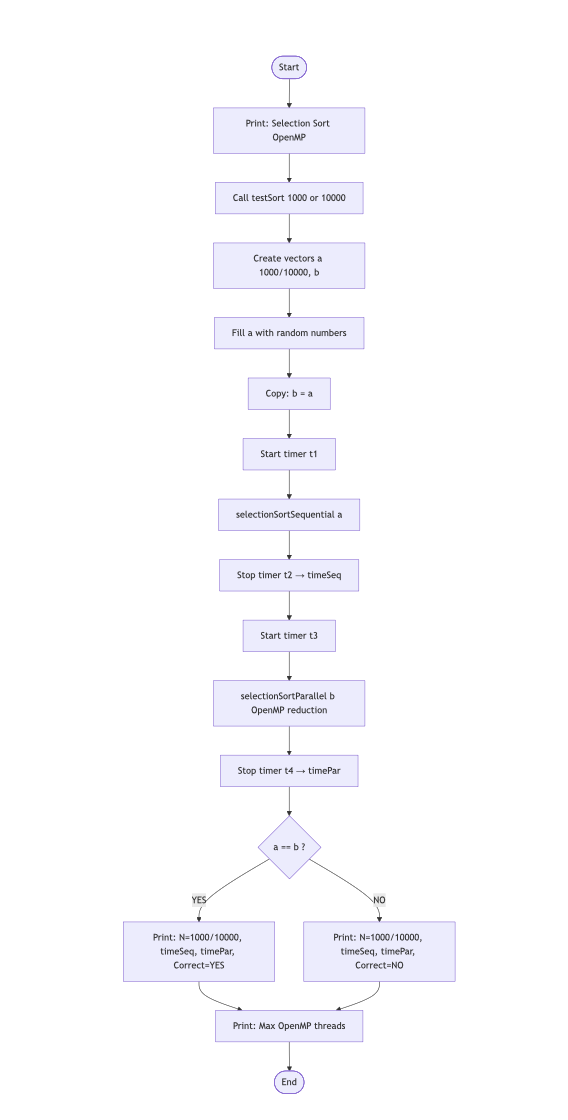



In [35]:
%%writefile task3.cpp
#include <iostream>                         // вывод в консоль (cout)
#include <vector>                           // контейнер vector
#include <random>                           // генератор случайных чисел
#include <chrono>                           // измерение времени
#include <algorithm>                        // swap
#include <omp.h>                            // OpenMP

using namespace std;                        // чтобы не писать std::

struct MinPair {                            // структура для минимума: значение + индекс
    int val;                                // значение минимума
    int idx;                                // индекс минимума
};

#pragma omp declare reduction(minpair: MinPair: omp_out = (omp_in.val < omp_out.val ? omp_in : omp_out)) initializer(omp_priv = omp_orig) // custom reduction

void selectionSortSequential(vector<int>& a) { // последовательная сортировка выбором
    int n = (int)a.size();                  // размер массива
    for (int i = 0; i < n - 1; i++) {       // внешний цикл по позиции i
        int minIndex = i;                   // считаем, что минимум сейчас в i
        for (int j = i + 1; j < n; j++) {   // ищем минимум справа от i
            if (a[j] < a[minIndex])         // если нашли меньше
                minIndex = j;               // обновляем индекс минимума
        }
        swap(a[i], a[minIndex]);            // ставим минимум на позицию i
    }
}

void selectionSortParallel(vector<int>& a) { // параллельная сортировка выбором (поиск минимума параллельно)
    int n = (int)a.size();                  // размер массива
    for (int i = 0; i < n - 1; i++) {       // внешний цикл остаётся последовательным
        MinPair best{a[i], i};              // текущий лучший минимум (значение + индекс)

        #pragma omp parallel for reduction(minpair: best) // каждый поток ищет локальный минимум, потом reduction выбирает общий
        for (int j = i + 1; j < n; j++) {   // параллельный проход по неотсортированной части
            if (a[j] < best.val)            // если текущий элемент меньше локального best
                best = {a[j], j};           // обновляем локальный best
        }

        if (best.idx != i)                 // если минимум не уже на месте
            swap(a[i], a[best.idx]);       // один swap после параллельного поиска
    }
}

void testSort(int N) {                      // тестирование на массиве размера N
    vector<int> a(N);                       // массив для последовательной версии
    vector<int> b;                          // массив для параллельной версии

    mt19937 rng(42);                        // генератор с фиксированным seed
    uniform_int_distribution<int> dist(0, 100000); // диапазон случайных чисел

    for (int i = 0; i < N; i++)             // заполняем массив
        a[i] = dist(rng);                   // записываем случайное число

    b = a;                                  // делаем копию для честного сравнения

    auto t1 = chrono::high_resolution_clock::now(); // старт таймера для seq
    selectionSortSequential(a);             // сортируем последовательно
    auto t2 = chrono::high_resolution_clock::now(); // конец таймера для seq
    double timeSeq = chrono::duration<double, milli>(t2 - t1).count(); // время seq в мс

    auto t3 = chrono::high_resolution_clock::now(); // старт таймера для OpenMP
    selectionSortParallel(b);               // сортируем параллельно (поиск минимума)
    auto t4 = chrono::high_resolution_clock::now(); // конец таймера для OpenMP
    double timePar = chrono::duration<double, milli>(t4 - t3).count(); // время omp в мс

    bool ok = (a == b);                     // проверяем, что результаты одинаковые

    cout << "N = " << N << "\n";            // вывод размера
    cout << "Sequential time: " << timeSeq << " ms\n"; // вывод времени seq
    cout << "Parallel time:   " << timePar << " ms\n"; // вывод времени omp
    cout << "Correct: " << (ok ? "YES" : "NO") << "\n\n"; // корректность
}

int main() {                                // основная функция
    cout << "Selection Sort (OpenMP)\n";    // заголовок

    testSort(1000);                         // тест N=1000
    testSort(10000);                        // тест N=10000

    cout << "Max OpenMP threads: " << omp_get_max_threads() << "\n"; // доступные потоки
    return 0;                               // конец
}


Overwriting task3.cpp


In [36]:
!g++ -O2 -fopenmp task3.cpp -o task3
!OMP_NUM_THREADS=2 ./task3

Selection Sort (OpenMP)
N = 1000
Sequential time: 0.471194 ms
Parallel time:   1.1235 ms
Correct: YES

N = 10000
Sequential time: 39.6489 ms
Parallel time:   40.0643 ms
Correct: YES

Max OpenMP threads: 2


### Вывод

Результаты сортировки совпадают, что подтверждает корректность программы. Для массива из 1000 элементов параллельная версия работает немного медленнее из-за накладных расходов OpenMP. Для массива из 10 000 элементов время выполнения последовательной и параллельной версий почти одинаковое, так как сортировка выбором в основном является последовательным алгоритмом и плохо подходит для параллелизации.

Задача 4. Сортировка на GPU с использованием CUDA
Практическое задание (25 баллов)
Реализуйте параллельную сортировку слиянием на GPU с использованием CUDA:

*   разделите массив на подмассивы, каждый из которых обрабатывается
отдельным блоком;
*   выполните параллельное слияние отсортированных подмассивов;
*   замерьте производительность для массивов размером 10 000 и 100 000
элементов.

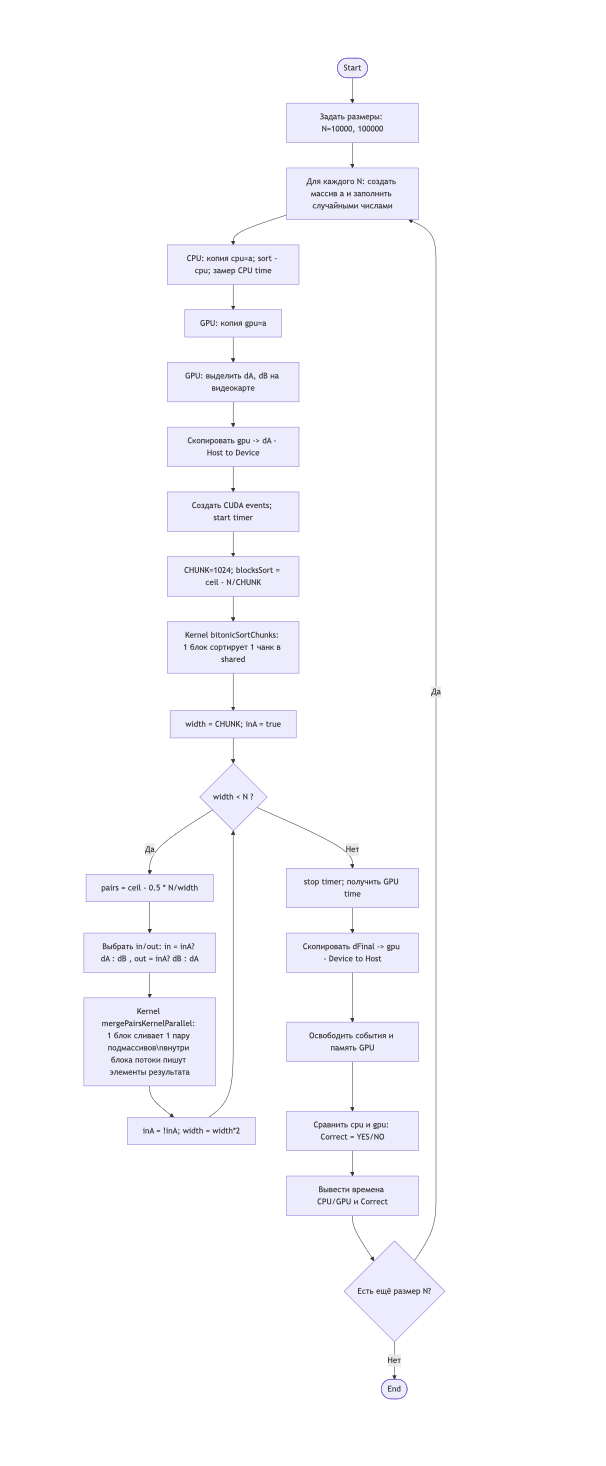


In [50]:
!nvidia-smi
!nvcc --version


Mon Dec 29 12:48:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [76]:
%%writefile task4.cu
// Подключаем основные заголовки CUDA для работы с GPU
#include <cuda_runtime.h>
#include <device_launch_parameters.h>

// Подключаем стандартные библиотеки C++
#include <iostream>     // ввод-вывод
#include <vector>       // контейнер vector
#include <algorithm>    // sort
#include <random>       // генератор случайных чисел
#include <chrono>       // измерение времени
#include <climits>      // INT_MAX и INT_MIN

// Используем стандартное пространство имён
using namespace std;

// Макрос для проверки ошибок CUDA
#define CUDA_CHECK(call) do {                                   \
    cudaError_t err = (call);                                   \
    if (err != cudaSuccess) {                                   \
        cerr << "CUDA error: " << cudaGetErrorString(err)       \
             << " at " << __FILE__ << ":" << __LINE__ << "\n";  \
        exit(1);                                                \
    }                                                           \
} while(0)


//==============================================================
// 1) Сортировка чанков: один блок сортирует один подмассив
//==============================================================

// Шаблон ядра: размер чанка задаётся параметром CHUNK
template<int CHUNK>
__global__ void bitonicSortChunks(int* a, int n) {

    // Разделяемая память для текущего чанка
    __shared__ int s[CHUNK];

    // Индекс потока внутри блока
    int t = threadIdx.x;

    // Начальный индекс чанка в глобальном массиве
    int start = blockIdx.x * CHUNK;

    // Глобальный индекс элемента
    int idx = start + t;

    // Загружаем данные из глобальной памяти в shared
    // Если вышли за границы массива — записываем INT_MAX
    s[t] = (idx < n) ? a[idx] : INT_MAX;

    // Ждём, пока все потоки загрузят данные
    __syncthreads();

    // Реализация bitonic sort внутри shared memory
    for (int k = 2; k <= CHUNK; k <<= 1) {
        for (int j = k >> 1; j > 0; j >>= 1) {

            // Индекс элемента для сравнения
            int ixj = t ^ j;

            if (ixj > t) {

                // Определяем направление сортировки (по возрастанию или убыванию)
                bool asc = ((t & k) == 0);

                // Берём значения для сравнения
                int x = s[t];
                int y = s[ixj];

                // Меняем местами элементы при необходимости
                if ((asc && x > y) || (!asc && x < y)) {
                    s[t] = y;
                    s[ixj] = x;
                }
            }

            // Синхронизация потоков на каждом шаге
            __syncthreads();
        }
    }

    // Записываем отсортированный чанк обратно в глобальную память
    if (idx < n)
        a[idx] = s[t];
}


//==============================================================
// 2) Параллельное слияние (merge-path)
//==============================================================

// Функция поиска разбиения диагонали для merge
__device__ __forceinline__
void mergePathPartition(const int* A, int aCount,
                        const int* B, int bCount,
                        int diag, int& aIdx, int& bIdx)
{
    // Минимально возможный индекс в A
    int aMin = max(0, diag - bCount);

    // Максимально возможный индекс в A
    int aMax = min(diag, aCount);

    // Бинарный поиск корректного разбиения
    while (aMin < aMax) {

        // Пробуем середину диапазона
        int aMid = (aMin + aMax) >> 1;
        int bMid = diag - aMid;

        // Берём соседние элементы для сравнения
        int aLeft  = (aMid > 0)      ? A[aMid - 1] : INT_MIN;
        int bLeft  = (bMid > 0)      ? B[bMid - 1] : INT_MIN;
        int aRight = (aMid < aCount) ? A[aMid]     : INT_MAX;
        int bRight = (bMid < bCount) ? B[bMid]     : INT_MAX;

        // Корректируем границы поиска
        if (aLeft > bRight) {
            aMax = aMid;         // Взяли слишком много из A
        }
        else if (bLeft > aRight) {
            aMin = aMid + 1;     // Взяли слишком мало из A
        }
        else {
            aMin = aMid;         // Нашли корректное разбиение
            break;
        }
    }

    // Возвращаем найденные индексы
    aIdx = aMin;
    bIdx = diag - aMin;
}


// Ядро параллельного слияния двух отсортированных подмассивов
__global__ void mergePairsKernelParallel(const int* __restrict__ in,
                                         int* __restrict__ out,
                                         int n, int width)
{
    // Начальный индекс пары подмассивов
    int start = blockIdx.x * (2 * width);

    // Если вышли за границы массива — выходим
    if (start >= n) return;

    // Вычисляем границы двух подмассивов
    int mid = min(start + width, n);
    int end = min(start + 2 * width, n);

    // Указатели на подмассивы
    const int* A = in + start;
    const int* B = in + mid;

    // Размеры подмассивов
    int aCount = mid - start;
    int bCount = end - mid;

    // Общее количество элементов
    int total  = aCount + bCount;

    // Каждый поток обрабатывает несколько элементов результата
    for (int k = threadIdx.x; k < total; k += blockDim.x) {

        int aIdx, bIdx;

        // Находим, какие элементы брать из A и B
        mergePathPartition(A, aCount, B, bCount, k, aIdx, bIdx);

        // Берём текущие значения
        int aVal = (aIdx < aCount) ? A[aIdx] : INT_MAX;
        int bVal = (bIdx < bCount) ? B[bIdx] : INT_MAX;

        // Записываем минимальный элемент в выходной массив
        out[start + k] = (aVal <= bVal) ? aVal : bVal;
    }
}


//==============================================================
// GPU merge sort
//==============================================================

// Функция сортировки массива на GPU
float gpuMergeSortParallelMerge(vector<int>& data) {

    // Размер массива
    int n = (int)data.size();

    // Указатели на память GPU
    int* dA = nullptr;
    int* dB = nullptr;

    // Выделяем память на GPU
    CUDA_CHECK(cudaMalloc(&dA, n * sizeof(int)));
    CUDA_CHECK(cudaMalloc(&dB, n * sizeof(int)));

    // Копируем данные с CPU на GPU
    CUDA_CHECK(cudaMemcpy(dA, data.data(),
                          n * sizeof(int),
                          cudaMemcpyHostToDevice));

    // Синхронизация (прогрев GPU)
    CUDA_CHECK(cudaDeviceSynchronize());

    // Создаём CUDA события для замера времени
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));

    // Начало измерения времени
    CUDA_CHECK(cudaEventRecord(start));

    // Размер чанка (степень двойки)
    constexpr int CHUNK = 1024;

    // Количество блоков для сортировки чанков
    int blocksSort = (n + CHUNK - 1) / CHUNK;

    // Сортировка чанков
    bitonicSortChunks<CHUNK><<<blocksSort, CHUNK>>>(dA, n);
    CUDA_CHECK(cudaGetLastError());

    // Начальная ширина для слияния
    int width = CHUNK;

    // Флаг, где находятся актуальные данные
    bool inA = true;

    // Последовательные проходы merge
    while (width < n) {

        // Количество пар подмассивов
        int pairs = (n + (2 * width) - 1) / (2 * width);

        // Выбираем входной и выходной массив
        const int* in = inA ? dA : dB;
        int* out      = inA ? dB : dA;

        // Запуск параллельного слияния
        mergePairsKernelParallel<<<pairs, 256>>>(in, out, n, width);
        CUDA_CHECK(cudaGetLastError());

        // Меняем массивы местами
        inA = !inA;

        // Увеличиваем ширину в 2 раза
        width *= 2;
    }

    // Конец измерения времени
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));

    // Получаем время выполнения
    float ms = 0.0f;
    CUDA_CHECK(cudaEventElapsedTime(&ms, start, stop));

    // Выбираем финальный массив
    int* dFinal = inA ? dA : dB;

    // Копируем результат обратно на CPU
    CUDA_CHECK(cudaMemcpy(data.data(),
                          dFinal,
                          n * sizeof(int),
                          cudaMemcpyDeviceToHost));

    // Освобождаем ресурсы
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
    CUDA_CHECK(cudaFree(dA));
    CUDA_CHECK(cudaFree(dB));

    // Возвращаем время GPU
    return ms;
}


//==============================================================
// main: замеры для 10000 и 100000
//==============================================================
int main() {

    // Размеры массивов для тестирования
    vector<int> sizes = {10000, 100000};

    // Генератор случайных чисел
    mt19937 rng(42);
    uniform_int_distribution<int> dist(0, 1000000);

    // Проходим по всем размерам
    for (int N : sizes) {

        // Создаём массив
        vector<int> a(N);

        // Заполняем случайными числами
        for (int i = 0; i < N; i++)
            a[i] = dist(rng);

        // Копия для CPU
        vector<int> cpu = a;

        // Замер времени CPU
        auto c1 = chrono::high_resolution_clock::now();
        sort(cpu.begin(), cpu.end());
        auto c2 = chrono::high_resolution_clock::now();

        double cpuMs =
            chrono::duration<double, milli>(c2 - c1).count();

        // Копия для GPU
        vector<int> gpu = a;

        // Запуск сортировки на GPU
        float gpuMs = gpuMergeSortParallelMerge(gpu);

        // Проверка корректности
        bool ok = (cpu == gpu);

        // Вывод результатов
        cout << "N = " << N << "\n";
        cout << "CPU time: " << cpuMs << " ms\n";
        cout << "GPU time: " << gpuMs << " ms\n";
        cout << "Correct: " << (ok ? "YES" : "NO") << "\n\n";
    }

    // Завершение программы
    return 0;
}



Overwriting task4.cu


In [77]:
!nvcc -O2 -arch=sm_75 task4.cu -o task4
!./task4

N = 10000
CPU time: 0.511158 ms
GPU time: 0.538624 ms
Correct: YES

N = 100000
CPU time: 6.42855 ms
GPU time: 4.53062 ms
Correct: YES



### Вывод

В данной работе была реализована параллельная сортировка слиянием на GPU с помощью CUDA. Массив разбивался на части, которые сортировались параллельно, после чего выполнялось их слияние. Были измерены времена работы программы для разных размеров входных данных.
По результатам экспериментов видно, что при небольшом размере массива преимущество GPU незначительно, однако при увеличении объёма данных время выполнения на GPU становится меньше, чем на CPU. Полученные результаты сортировки совпадают с эталонной реализацией на CPU, что говорит о правильности работы программы.

# Контрольные вопросы к Assignment 2
(OpenMP, CUDA и гетерогенные вычисления)
1. Что понимается под гетерогенной параллелизацией?

Гетерогенная параллелизация — это когда в вычислениях одновременно используются разные устройства, например CPU и GPU, и каждая часть задачи выполняется там, где это эффективнее.

2. В чём принципиальные различия архитектур CPU и GPU?

CPU имеет мало, но мощных ядер, хорошо подходит для сложной логики и последовательных задач.
GPU имеет очень много простых ядер, которые хорошо выполняют однотипные операции параллельно.

3. Какие типы задач лучше подходят для выполнения на GPU, а какие — на CPU?

На GPU лучше выполнять массовые однотипные вычисления, например обработку массивов или матриц.
На CPU лучше выполнять задачи с условиями, ветвлениями и управлением программой.

4. Почему не все алгоритмы эффективно распараллеливаются с использованием OpenMP?

Потому что во многих алгоритмах есть зависимости между шагами, и их нельзя выполнять одновременно. Также параллелизация может давать большие накладные расходы.

5. В чём заключается основная идея алгоритма сортировки слиянием?

Массив делится на части, каждая часть сортируется, после чего отсортированные части сливаются в один общий отсортированный массив.

6. Какие сложности возникают при реализации сортировки слиянием на GPU?

Сложно организовать параллельное слияние, управлять памятью GPU и правильно синхронизировать потоки между собой.

7. Как выбор размера блока и сетки влияет на производительность вычислений на GPU?

Если размеры выбраны неправильно, GPU используется не полностью.
Правильный выбор позволяет лучше загрузить вычислительные блоки и ускорить выполнение программы.

8. Почему гетерогенный подход может быть эффективнее использования только CPU или только GPU?

Потому что CPU и GPU дополняют друг друга: CPU выполняет управление и сложную логику, а GPU — тяжёлые параллельные вычисления, что даёт лучший общий результат.